# Particle initial positions

*PyLag* must be given the initial positions of particles at the start of each new simulation. When running *PyLag* from the command line, particle initial positions can be specified in one of two ways. In the first approach, particle initial positions are read in from a text file with a specified format, as outlined below. In the second approach, particle initial positions are read from a restart file which has been created at the end of or during a previous simulation. The choice is specified in the run configuration file. In *pylag-tools*, a number tools have been provided to help with the creation of particle initial position files. These are described below.

## Release zones

To assist with connectivty studies, support for the creation of individual circular *release zones* has been added. In *PyLag-tools*, any number of particles can be placed in a release zone and their positions recorded in an initial positions file. Particles may be either *regularly* or *randomly* distributed within the zone. The former method is discontinuous, and only the latter guarantees that the specified number of particles will be added. If all particles that start out in a given *release zone* are given the same *group ID*, they can easily be tracked as a group. The following code illustrates the two ways in which particles can be scattered within a release zone.

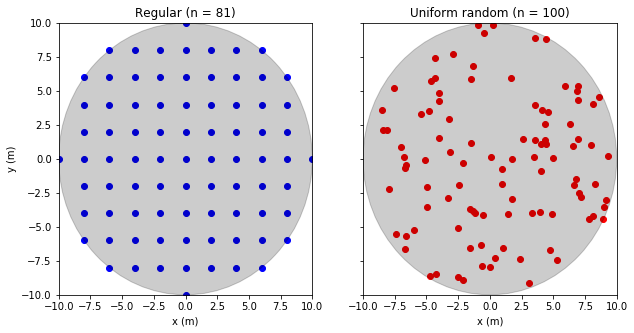

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from pylagtools.release_zone import create_release_zone

# Set particle properties
group_id = 1                 # Particle group ID
n_particles = 100            # Number of particles per release zone
radius = 10.0                # Release zone radius
centre = [0.0,0.0] # (x,y) coordinates of the release zone's centre
depth = 0.0                  # Depth of particles

# Create figure for plotting
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,5))

# Regularly spaced particles (with random=False)
# ----------------------------------------------
release_zone_reg = create_release_zone(group_id, radius, centre, n_particles,
                                       depth, random=False)

eastings_reg, northings_reg, depth_reg = release_zone_reg.get_coords()
ax1.scatter(eastings_reg, northings_reg, c='b', marker='o')
ax1.add_patch(plt.Circle(centre, radius=radius, color='k', alpha=0.2))
ax1.set_title('Regular (n = {})'.format(
        release_zone_reg.get_number_of_particles()))
ax1.set_xlim(-radius,radius)
ax1.set_ylim(-radius,radius)
ax1.set_xlabel('x (m)')
ax1.set_ylabel('y (m)')

# Randomly spaced particles (with random=True)
# ----------------------------------------------
release_zone_rand = create_release_zone(group_id, radius, centre, n_particles, 
                                        depth, random=True)
eastings_rand, northings_rand, depth_rand = release_zone_rand.get_coords()
ax2.scatter(eastings_rand, northings_rand, c='r', marker='o')
ax2.add_patch(plt.Circle(centre, radius=radius, color='k', alpha=0.2))
ax2.set_title('Uniform random (n = {})'.format(
        release_zone_rand.get_number_of_particles()))
ax2.set_xlim(-radius,radius)
ax2.set_ylim(-radius,radius)
ax2.set_xlabel('x (m)')

plt.show()

In applied work, it is often desirable to create a set of distinct release zones, each containing some number of particles. In addition to the creation of single release zones, *PyLag-tools* includes functionality that makes it possible to create sets of release zones. Two standard approaches are supported: a) the creation of a set of release zones along a specified cord, and b) the creation of a set of release zones along the edge of a polygon. The latter method has been introduced to make it possible to create sets of adjacent release zones that follow a coastline defined by a given polygon at some spefied fixed distance from the shore. Both approaches are described below.

### Release zones along a cord

A set of adjacent, non-overlapping release zones along a cord can be created in the following way.

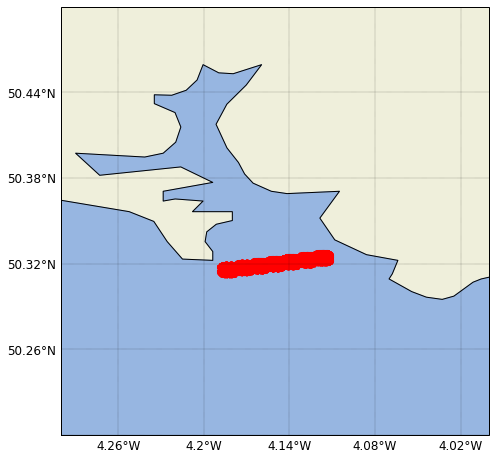

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from PyFVCOM.coordinate import utm_from_lonlat, lonlat_from_utm

from pylagtools.release_zone import create_release_zones_along_cord
from pylagtools.plot import create_figure

def plot_release_zone_locations(release_zones, extents):

    # Create figure
    font_size = 12
    projection = ccrs.PlateCarree()
    fig, ax = create_figure(figure_size=(20., 20.), font_size=font_size,
                            projection=projection)

    # Plot the location of particles in each release zone
    for zone in release_zones:
        lons, lats = lonlat_from_utm(zone.get_eastings(), zone.get_northings(), zone='30N')
        ax.scatter(lons, lats, zorder=2, transform=projection, marker='x', color='r')    

    # Tidy up the plot
    ax.set_extent(extents, projection)
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                                edgecolor='face',
                                                facecolor=cfeature.COLORS['land']))
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '10m',
                                                edgecolor='face',
                                                facecolor=cfeature.COLORS['water']))
    ax.coastlines(resolution='10m')
    gl = ax.gridlines(linewidth=0.2, draw_labels=True, linestyle='--', color='k')
    gl.xlabel_style = {'fontsize': font_size}
    gl.ylabel_style = {'fontsize': font_size}
    gl.xlabels_top=False
    gl.ylabels_right=False
    gl.xlabels_bottom=True
    gl.ylabels_left=True
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
# Define some common properties for release zones
n_particles = 1000            # Number of particles per release zone
radius = 400.0               # Release zone radius (m)
depth = 0.0                  # Depth that particles will be released at

# Position vector of a point toward the LHS of the Tamar Estuary (lon, lat)
coords_lhs = np.array([-4.19, 50.315])

# Position vector of a point toward the RHS of the Tamar Estuary (lon, lat)
coords_rhs = np.array([-4.11, 50.325])

# Convert to UTM coordinates
eastings, northings, _ = utm_from_lonlat([coords_lhs[0], coords_rhs[0]],
                                         [coords_lhs[1], coords_rhs[1]],
                                         zone='30N')

# Position vectors in UTM coordinates
coords_utm_lhs = np.array([eastings[0], northings[0]])
coords_utm_rhs = np.array([eastings[1], northings[1]])

# Create release zones
release_zones = create_release_zones_along_cord(coords_utm_lhs, coords_utm_rhs, radius=radius, 
        n_particles=n_particles, depth=depth, random=True)

# Plot
plot_release_zone_locations(release_zones, [-4.3, -4.0, 50.2, 50.5])

plt.show()

In the figure, each circle is populated with particles. In total, five release zones have been created. The circular shape of each release zone can be discerned from the position of particles.

### Release zones around an arbitrary polygon

A second practical case is the need to create release zones around an arbitrary shape such as an island or country. To demonstrate this functionality, we use an example shapefile which follows the coast of the UK at a distance of 10 km. The shapefile was created using [QGIS](https://www.qgis.org/en/site/) and version 2.3.3 of the [GSHHG dataset](https://www.ngdc.noaa.gov/mgg/shorelines/).

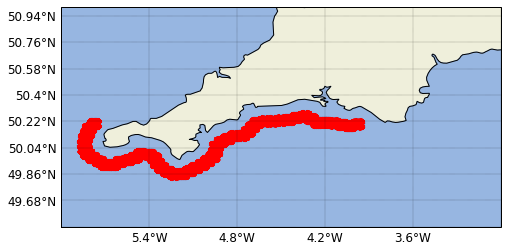

In [3]:
import shapefile

from pylagtools.release_zone import create_release_zones_around_shape_section

start = (-4.0, 50.3)   # Lon/Lat coordinates for the approximate location of the
                       # first release zone to be created
target_length = 2.0e5  # Target length of path along which to create release
                       # zones (m)
radius = 2.0e3         # Release zone radius (m)
n_particles = 1000     # No. of particles per release zone

# Sample shapefile covering mainland UK
shp = shapefile.Reader('./resources/ref_shapefile')
shape_obj = shp.shape(0)

# Create release zones
release_zones = create_release_zones_around_shape_section(shape_obj, start, 
        target_length, group_id, radius, n_particles, check_overlaps=True)

# Plot
plot_release_zone_locations(release_zones, [-6.0, -3.0, 49.5, 51.0])

plt.show()

## Initial position files

Initial position files are simple text files with the following format:

```
n
group_id x1 x2 x3
group_id x1 x2 x3
...
```

The entries have the following meaning:

* **n** is the total number of particles. It must always be the first entry in the file.
* **group_id** is an integer number that can be used to group particles. This can be useful if, say, you want to look at a group of particles that started off from a similar location. It does not affect particle dynamics. It is recorded in the simulation output files.
* **x1** is the particle's first position coordinate. In a cartesian coordinate system, this should be *x* in meters. In a spherical polar coordinate system, it should be the particle's longitude in degrees east.
* **x2** is the particle's second position coordinate. In a cartesian coordinate system, this should be *y* in meters. In a spherical polar coordinate system, it should be the particle's latitude degrees north.
* **x3** is the particle's third position coordinate. This is always the particle's depth, *z*, in meters. *z* can be given relative to the moving free surface or the sea floor. The choice is set in the [run configuration file](./configuration.ipynb) using the option `depth_coordinates`. Depth is positive up. Thus, if `depth_coordinates` is set to `depth_below_surface`, a depth, $z$, of -0.1 would specify a starting *z* position 0.1 m below the free surface. The model will interpolate the free surface height to the particle's position in time and space, so you don't need to worry about what the sea surface height is at a particlular point in time (unless you set a starting depth that lies below the sea floor). There is also an option to start particles off from a specified distance above the sea floor.

For example, an initial positions file, `initial_positions.dat`, for a simulation involving two particles with the same group ID, whose lateral coordinates are given in degrees and initial vertical coordinates are coincident with the free surface, might look like:

```
2
1 -4.17 50.0 0.0
1 -4.17 50.1 0.0
```

For simulations involving tens of particles or more, the initial positions file is most easily created programatically.

### Creating initial position files

Two methods have been included to assist with the writing of initial position files. The first will create a correctly formatted initial positions file for a single group of particles. The second, which is designed to be used with data for multiple particle groups, will create an initial positions file when given a list of release zone objects.

Below, we create a temporary directory called `example_initial_position_files`, and create within it two initial positions files: one for a single group of particles and the second for multiple groups of particles.

In [4]:
import os

from pylagtools.input import create_initial_positions_file_single_group
from pylagtools.input import create_initial_positions_file_multi_group

# Create input sub-directory
test_dir = './example_initial_position_files'
try:
    os.makedirs(test_dir)
except FileExistsError:
    pass

# Single group
# ------------

# Output filename
file_name = '{}/initial_positions_single_group.dat'.format(test_dir)

# Write test data to file
n_particles = 2
group_id = 1 
lons = np.array([-4.16, -4.5])
lats = np.array([50.25, 50.26])
depths = np.array([0.0, 0.0])
create_initial_positions_file_single_group(file_name,
                                           n_particles,
                                           group_id,
                                           lons,
                                           lats,
                                           depths)

# Multi group
# -----------

# Output filename
file_name = '{}/initial_positions_multi_group.dat'.format(test_dir)

# Here, we reuse the release zone object created previously
create_initial_positions_file_multi_group(file_name, release_zones)